# `pairtools`: Convert sequencing data to a list of contacts

In [7]:
%%bash 

cd ../steps/bowtie2/local/bamfiles

samtools view SRR6502335_1.bam | head -n1

SRR6502335.1	16	chr2	194419849	44	149M1S	*	0	0	AGAGAGAAAGAGTAGAAGGGAGAAACAAAGGGCAGGAGAGGGGATAGATGAAGAGGAACTAGACTTTGCACATATTGGCTGGCAATGATGGAATAGTCCAGTTTCAAAGAGTGAGATCTTGTAGTTATCTTCTCATTTATTCACTTAATN	<FFAF-J7AJJA7AFA77-<AAF-7-A7-7A7-FJ<FA7FAA-7--AAA--<<A7FFJAJJJA<-A-F7F7<-A<F7---<A<JJFFAAF7JFAAJ<FFJF-<-FJJFFFFFJFAF<<-AJJJJJFFF-JFJFFJF7AFJFFFAA-AAA#	AS:i:285	XN:i:0	XM:i:2	XO:i:0	XG:i:0	NM:i:2	MD:Z:44G78A25	YT:Z:UU


# HiC data analysis with `cooler` and `cooltools`

## Introduction 

First, we have to check the data output from HiCExplorer. The output is a `.cool` file, which is a binary format for storing Hi-C data. The file contains the binned contact matrix and the genomic coordinates of the bins.

The `cooler` package is a Python library for working with `.cool` files. It provides tools for reading, writing, and manipulating Hi-C data. The `cooltools` package is a collection of tools for analyzing Hi-C data, including normalization, visualization, and interaction calling.

## Follow `cooler` walkthrough from the documentation

In [2]:
# Import the packages we will use
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas
import h5py

import cooler

In [3]:
# The following directive activates inline plotting
%matplotlib inline

In [4]:
# Define the filepath (I choose the uncorrected matrix)

filepath = "../steps/bowtie2/local/matrices/filtered_pooled_10kb.cool"


### Direct access with `h5py`

In [5]:
h5 = h5py.File(filepath, 'r')
h5

<HDF5 file "filtered_pooled_10kb.cool" (mode r)>

In [6]:
h5.keys()

<KeysViewHDF5 ['bins', 'chroms', 'indexes', 'pixels']>

In [7]:
h5['pixels']

<HDF5 group "/pixels" (3 members)>

In [8]:
list(h5['pixels'].keys())

['bin1_id', 'bin2_id', 'count']

h5py dataset objects are views onto the data on disk

In [9]:
h5['pixels']['bin2_id']

<HDF5 dataset "bin2_id": shape (117090191,), type "<i4">

Slicing or indexing returns a numpy array in memory.

In [10]:
h5['pixels']['bin2_id'][:10]

array([   0,    9,   30,   33,  124,  127,  145,  756, 1167, 2416],
      dtype=int32)

In [11]:
h5['pixels']['count'][:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:
h5.close()

The Python cooler package is just a thin wrapper over h5py.

* It lets you access the data tables as Pandas data frames and series.
* It also provides a matrix abstraction: letting you query the upper triangle pixel table as if it were a full rectangular sparse matrix via SciPy.

### The `Cooler` class

Accepts a file path or an open HDF5 file object.

NOTE: Using a filepath allows the `Cooler` object to be  serialized/pickled since the file is only opened when needed

In [13]:
c = cooler.Cooler(filepath)

In [14]:
c.info

{'bin-size': 10000,
 'bin-type': 'fixed',
 'creation-date': '2024-09-24T21:20:38.656143',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/mirnylab/cooler',
 'format-version': 3,
 'generated-by': 'HiCMatrix-17.2',
 'generated-by-cooler-lib': 'cooler-0.10.2',
 'genome-assembly': 'unknown',
 'metadata': {'format': 'HDF5::Cooler',
  'format-url': 'https://github.com/mirnylab/cooler',
  'generated-by': 'HiCMatrix-17.2',
  'generated-by-cooler-lib': 'cooler-0.10.2',
  'tool-url': 'https://github.com/deeptools/HiCMatrix'},
 'nbins': 285406,
 'nchroms': 22,
 'nnz': 117090191,
 'storage-mode': 'symmetric-upper',
 'sum': 193589731.0,
 'tool-url': 'https://github.com/deeptools/HiCMatrix'}

In [15]:
c.chroms()

The return value is a selector or "view" on a table that accepts column and range queries ("slices").

* Column selections return a new view.
* Range selections return pandas DataFrames or Series.

In [16]:
# Get a slice of the chromosomes
c.chroms()[0:5]

# Or the whole dict
#c.chroms()[:]

,name,length
0,chr1,223616942
1,chr2,196197964
2,chr3,185288947
3,chr4,169963040
4,chr5,187317192


In [17]:
# Convenience
c.chromnames, c.chromsizes

(['chr1',
  'chr2',
  'chr3',
  'chr4',
  'chr5',
  'chr6',
  'chr7',
  'chr8',
  'chr9',
  'chr10',
  'chr11',
  'chr12',
  'chr13',
  'chr14',
  'chr15',
  'chr16',
  'chr17',
  'chr18',
  'chr19',
  'chr20',
  'chrX',
  'chrY'],
 name
 chr1     223616942
 chr2     196197964
 chr3     185288947
 chr4     169963040
 chr5     187317192
 chr6     179085566
 chr7     169868564
 chr8     145679320
 chr9     134124166
 chr10     99517758
 chr11    133066086
 chr12    130043856
 chr13    108737130
 chr14    128056306
 chr15    113283604
 chr16     79627064
 chr17     95433459
 chr18     74474043
 chr19     58315233
 chr20     77137495
 chrX     153388924
 chrY      11753682
 Name: length, dtype: int32)

In [18]:
# Access bins
c.bins()[:10]

,chrom,start,end
0,chr1,0,10000
1,chr1,10000,20000
2,chr1,20000,30000
3,chr1,30000,40000
4,chr1,40000,50000
5,chr1,50000,60000
6,chr1,60000,70000
7,chr1,70000,80000
8,chr1,80000,90000
9,chr1,90000,100000


Selecting a list of columns returns a new DataFrame view on that subset of columns

In [19]:
bins = c.bins()[['chrom', 'start', 'end']]
bins

In [20]:
bins[:5]

,chrom,start,end
0,chr1,0,10000
1,chr1,10000,20000
2,chr1,20000,30000
3,chr1,30000,40000
4,chr1,40000,50000


The pixel table contains the non-zero upper triangle entries of the contact map.

In [21]:
# Use the join=True option if you would like to expand the bin IDs into genomic bin coordinates by joining the output with the bin table.

display(c.pixels()[:10], c.pixels(join=True)[:10])

,bin1_id,bin2_id,count
0,0,0,1.0
1,0,9,1.0
2,0,30,1.0
3,0,33,1.0
4,0,124,1.0
5,0,127,1.0
6,0,145,1.0
7,0,756,1.0
8,0,1167,1.0
9,0,2416,1.0


,chrom1,start1,end1,chrom2,start2,end2,count
0,chr1,0,10000,chr1,0,10000,1.0
1,chr1,0,10000,chr1,90000,100000,1.0
2,chr1,0,10000,chr1,300000,310000,1.0
3,chr1,0,10000,chr1,330000,340000,1.0
4,chr1,0,10000,chr1,1240000,1250000,1.0
5,chr1,0,10000,chr1,1270000,1280000,1.0
6,chr1,0,10000,chr1,1450000,1460000,1.0
7,chr1,0,10000,chr1,7560000,7570000,1.0
8,chr1,0,10000,chr1,11670000,11680000,1.0
9,chr1,0,10000,chr1,24160000,24170000,1.0


Dump any table selection with pandas to tabular

In [22]:
df = c.pixels(join=True)[:100]

# df.to_csv('data/myselection.txt'), sep='\t', index=False, header=False) 

### Bin annotation

Another way to annotate the bins in a data frame of pixels is to use cooler.annotate. It does a left outer join from the bin1_id and bin2_id columns onto a data frame indexed by bin ID that describes the bins.

In [23]:
bins = c.bins()[:] # fetch all
pix = c.pixels()[100:110] # select some pixels
pix

,bin1_id,bin2_id,count
100,2,481,1.0
101,2,500,1.0
102,2,519,1.0
103,2,557,1.0
104,2,580,1.0
105,2,594,1.0
106,2,606,1.0
107,2,621,1.0
108,2,625,1.0
109,2,646,1.0


In [24]:
cooler.annotate(pix, bins)

,chrom1,start1,end1,chrom2,start2,end2,bin1_id,bin2_id,count
100,chr1,20000,30000,chr1,4810000,4820000,2,481,1.0
101,chr1,20000,30000,chr1,5000000,5010000,2,500,1.0
102,chr1,20000,30000,chr1,5190000,5200000,2,519,1.0
103,chr1,20000,30000,chr1,5570000,5580000,2,557,1.0
104,chr1,20000,30000,chr1,5800000,5810000,2,580,1.0
105,chr1,20000,30000,chr1,5940000,5950000,2,594,1.0
106,chr1,20000,30000,chr1,6060000,6070000,2,606,1.0
107,chr1,20000,30000,chr1,6210000,6220000,2,621,1.0
108,chr1,20000,30000,chr1,6250000,6260000,2,625,1.0
109,chr1,20000,30000,chr1,6460000,6470000,2,646,1.0


In [25]:
cooler.annotate(pix, bins[['start']], replace=False)

,start1,start2,bin1_id,bin2_id,count
100,20000,4810000,2,481,1.0
101,20000,5000000,2,500,1.0
102,20000,5190000,2,519,1.0
103,20000,5570000,2,557,1.0
104,20000,5800000,2,580,1.0
105,20000,5940000,2,594,1.0
106,20000,6060000,2,606,1.0
107,20000,6210000,2,621,1.0
108,20000,6250000,2,625,1.0
109,20000,6460000,2,646,1.0


### Enter the Matrix

Finally, the `matrix` method provides a 2D-sliceable view on the data. It allows you to query the data on file as a full rectangular contact matrix.

In [26]:
c.matrix()

In [27]:
arr = c.matrix(balance=False)[1000:1200, 1000:1200]
arr

array([[ 57.,  33.,   9., ...,   0.,   1.,   0.],
       [ 33.,  88.,  33., ...,   1.,   0.,   0.],
       [  9.,  33.,  74., ...,   0.,   0.,   0.],
       ...,
       [  0.,   1.,   0., ..., 104.,  27.,  12.],
       [  1.,   0.,   0., ...,  27., 118.,  46.],
       [  0.,   0.,   0., ...,  12.,  46., 135.]])

In [28]:
# Use sparse=True to return a scipy.sparse.coo_matrix in stead

mat = c.matrix(balance=False, sparse=True)[1000:1200,1000:1200]
mat

<200x200 sparse matrix of type '<class 'numpy.float64'>'
	with 26544 stored elements in COOrdinate format>

Convert to a 2D numpy array

In [29]:
arr = mat.toarray()
arr

array([[ 57.,  33.,   9., ...,   0.,   1.,   0.],
       [ 33.,  88.,  33., ...,   1.,   0.,   0.],
       [  9.,  33.,  74., ...,   0.,   0.,   0.],
       ...,
       [  0.,   1.,   0., ..., 104.,  27.,  12.],
       [  1.,   0.,   0., ...,  27., 118.,  46.],
       [  0.,   0.,   0., ...,  12.,  46., 135.]])

Notice that tha lower triangle has automatically been filled

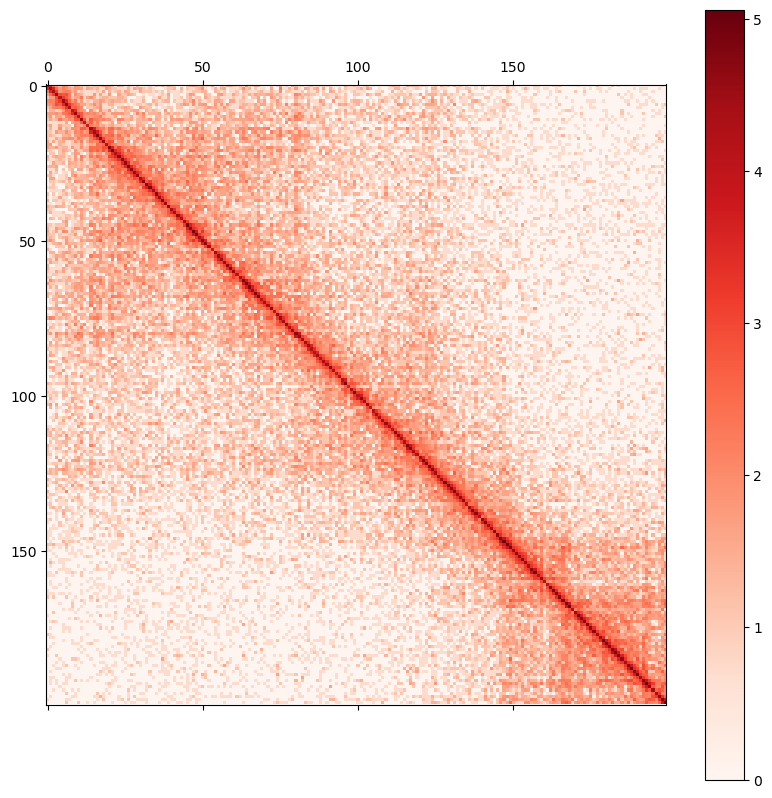

In [30]:
# Plot
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111)
im  = ax.matshow(np.log1p(arr), cmap='Reds')
fig.colorbar(im) 